In [ ]:
!pip install -U -t /kaggle/working/ git+https://github.com/Kaggle/learntools.git@nb-refactor

In [ ]:
import sys
sys.path.append('/kaggle/working')

In [ ]:
# Setup code. Make sure you run this first!

import os
import random
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

from learntools.core import binder; binder.bind(globals())
from learntools.embeddings.ex1_embedding_layers import *

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
# Load a 10% subset of the full MovieLens data.
df = pd.read_csv(os.path.join(input_dir, 'mini_rating.csv'))

print("Setup complete!")

Setup complete!


# Exercise (embeddings)

In this exercise, you'll add an enhancement to the embedding model from the previous lesson. To start, let's train a model with the same parameters so you have a baseline to compare against. **Run the cell below**. (It will take about 30 seconds, but you can start on part 1 while it runs.)

> *Aside*: Training the model in the tutorial took around a minute per epoch. To make training time more manageable, we'll be working with a sample of 10% of the total dataset (or around 2 million ratings). Therefore, we should expect our results to be generally worse than in the tutorial.

In [ ]:
# Some hyperparameters. Learning rate, number of epochs to train, number/size of hidden layers, size of embeddings
LR = .005
EPOCHS = 8
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

base_model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
base_model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)
history = base_model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=0,
    validation_split=.05,
);

Finished in 23.2s


## Adding biases

I propose an improvement to the model we trained in the tutorial: per-movie biases. In ML-speak, a **bias** is just a number that gets added to a node's output value. For each movie, we'll learn a single number that we'll add to the output of what was previously our final node. Here's what that looks like:

<img src="https://docs.google.com/a/google.com/drawings/d/e/2PACX-1vSmf5H7Rcr771flhidl7Wf31OXiZTUgNH2qzoVc-2dtH6Cf9XmSF3xQcY7m1RwCRBu2_lE-dH5Vb6ny/pub?w=1050&h=594" />

## Part 1: Why?

Do you think this will improve the accuracy of our predictions? Why or why not?

Think about it, then uncomment the line below to see an explanation.

In [ ]:
#part1.a.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> One basic observation is that adding biases gives our model more numbers to tune, and in this
sense it's strictly increasing its "capacity". This alone is a good enough reason to believe
adding biases will at least increase our accuracy on the training set (and possibly on the 
validation set, depending on how much we're already overfitting).

But we could also increase our model's capacity by just increasing the size of our embeddings, or
the number of hidden units. How does adding biases differ from that?

Do you have an idea about what the bias values will look like? Are there certain movies you expect will have high or low biases?

In [ ]:
#part1.b.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> Some movies are, on average, rated significantly higher or lower than others. 
In the tutorial, I mentioned that predicting the average rating per-movie gave much
better results than always predicting the global average. Per-movie biases are a simple
way for our model to account for the relative goodness or badness of movies. 

If the model does utilize the biases in this way, then we should expect the highest biases
to go to highly acclaimed movies like *The Godfather* or *Schindler's List*, and the lowest
biases to go to stinkers like *Battlefield Earth* or *Sharknado*.

This relates to the question I posed above: how is adding biases to our model different from 
increasing its capacity by making the embedding vectors bigger or adding hidden units? Because 
our biases get added at the very end, our model has a lot less flexibility in how to use them. 
And this can be a good thing. At a high level, we're imposing a prior belief - that some movies
are intrinsically better or worse than others. This is a form of regularization!

## Part 2: Coding it up

Below is the code we used to train our embedding model in the tutorial. Modify it (where indicated by the comments) to add per-movie biases.

In [ ]:
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating (before adding bias)
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

################################################################################
############################# YOUR CODE GOES HERE! #############################
# TODO: you need to create the variable movie_bias. Its value should be the output of calling a layer.
# I recommend giving the layer that holds your biases a distinctive name (this will help in an upcoming question)
#movie_bias = 
################################################################################
out = keras.layers.Add()([out, movie_bias])

model_bias = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_bias.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)
model_bias.summary()

part2.check()

No idea where to start? Don't panic! Uncomment and run the line below for some hints.

In [ ]:
#part2.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> 
1. Surprisingly, this is another use case for an embedding layer. Check out the docs 
on [keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
to review its parameters.
2. As with our existing use of Embedding layers, you may need to flatten its output to get rid of 
an extra dimension.

In [ ]:
#part2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> *(Note: this is the code that should go in the "YOUR CODE GOES HERE" section, not the full model definition.)*

```python
bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name='bias',
                                      )(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)
```


## Part 3: Training

Run the code below to train the model you built in the previous step.

In [ ]:
history_bias = model_bias.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);

Train on 1900000 samples, validate on 100000 samples
Epoch 1/8
 - 3s - loss: 0.8180 - mean_absolute_error: 0.7006 - val_loss: 0.7482 - val_mean_absolute_error: 0.6649
Epoch 2/8
 - 3s - loss: 0.7201 - mean_absolute_error: 0.6521 - val_loss: 0.7237 - val_mean_absolute_error: 0.6514
Epoch 3/8
 - 3s - loss: 0.6955 - mean_absolute_error: 0.6398 - val_loss: 0.7105 - val_mean_absolute_error: 0.6487
Epoch 4/8
 - 3s - loss: 0.6812 - mean_absolute_error: 0.6330 - val_loss: 0.7033 - val_mean_absolute_error: 0.6441
Epoch 5/8
 - 3s - loss: 0.6730 - mean_absolute_error: 0.6291 - val_loss: 0.6999 - val_mean_absolute_error: 0.6406
Epoch 6/8
 - 3s - loss: 0.6667 - mean_absolute_error: 0.6262 - val_loss: 0.6989 - val_mean_absolute_error: 0.6400
Epoch 7/8
 - 3s - loss: 0.6616 - mean_absolute_error: 0.6237 - val_loss: 0.6983 - val_mean_absolute_error: 0.6394
Epoch 8/8
 - 3s - loss: 0.6567 - mean_absolute_error: 0.6213 - val_loss: 0.6986 - val_mean_absolute_error: 0.6405


How does it compare to the results we got from the model without biases? Run the code cell below to compare their loss over the course of training.

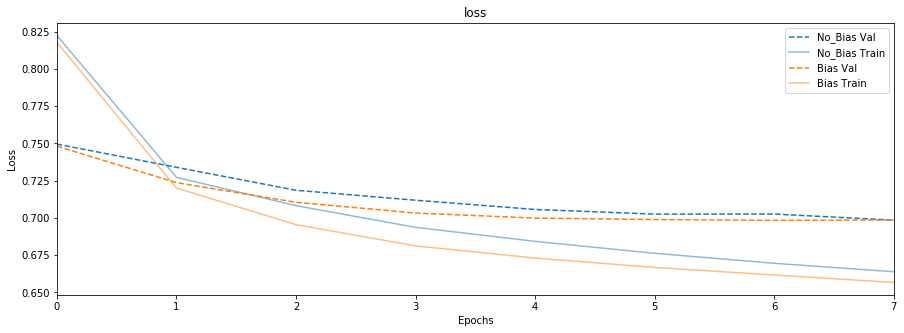

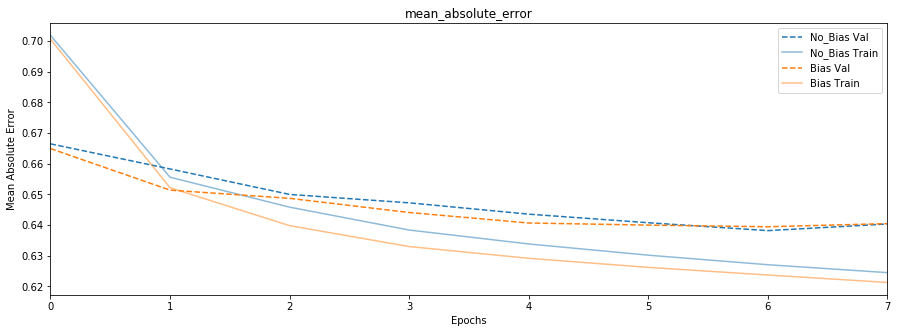

In [ ]:
history_FS = (15, 5)
def plot_history(histories, keys=('loss', 'mean_absolute_error'), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])

plot_history([ 
    ('no_bias', history),
    ('bias', history_bias),
]);

How did adding biases affect our results?

Averaged over many runs, biases seem to help a bit, but there's enough variance between runs (as a result of different random initializations), that you might be seeing better or worse results. If you're seeing a *big* difference (more than, say, +-.02 in the final loss) in either direction, something may have gone wrong.

So biases weren't the huge win we might have hoped for, but it still seems worth testing our hypothesis about how bias values will be distributed among movies.

## Part 4: Loading bias values

Let's take a look at the bias values our model has learned. Fill in the missing code in the cell below to load an array of bias values - `b` should be an array with one number for each movie in our training set.

**Hint:** you may want to check out the docs for [`keras.Model.get_layer`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#get_layer). This will be easier if you gave your `Embedding` bias layer a distinctive name in part 2. If you didn't, it may help to look at the output of `model_bias.summary()`.

In [ ]:
bias_layer = None

part4.check()

(b,) = bias_layer.get_weights()
print("Loaded biases with shape {}".format(b.shape))

<IPython.core.display.Javascript object>

<span style="color:#ccaa33">Check:</span> When you've updated the starter code, `check()` will tell you whether your code is correct. You need to update the code that creates variable `bias_layer`

AttributeError: 'NoneType' object has no attribute 'get_weights'

In [ ]:
#part4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> If you've given your bias layer a distinctive name, like 'bias', the following will work:

    bias_layer = model_bias.get_layer('bias')

Otherwise, you'll need to figure out what index your bias layer exists at (e.g. `bias_layer = model_bias.get_layer(index=8)`), or look up the name it was automatically assigned, e.g. `bias_layer = model_bias.get_layer('Embedding_1')`.

## Part 5: Exploring biases

Run the cell below to load a dataframe containing movie metadata and add the biases found in the previous step as a column.

In [ ]:
movies = pd.read_csv(os.path.join(input_dir, 'movie.csv'), index_col=0, 
                     usecols=['movieId', 'title', 'genres', 'year'])
ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)

# Mapping from original movie ids to canonical ones
mids = movieId_to_canon = df.groupby('movieId')['movieId_orig'].first()
# Add bias column
movies.loc[mids.values, 'bias'] = b
# Add columns for number of ratings and average rating
g = df_train.groupby('movieId_orig')
movies.loc[mids.values, 'n_ratings'] = g.size()
movies.loc[mids.values, 'mean_rating'] = g['rating'].mean()

movies.head()

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0.368075,4631.0,3.931656
1,Jumanji,Adventure|Children|Fantasy,1995,-0.090298,2097.0,3.221984
2,Grumpier Old Men,Comedy|Romance,1995,-0.150043,1202.0,3.155158
3,Waiting to Exhale,Comedy|Drama|Romance,1995,-0.420308,261.0,2.955939
4,Father of the Bride Part II,Comedy,1995,-0.236686,1175.0,3.089362


Which movies have the lowest and highest learned biases? Run the cell below to find out.

In [ ]:
from IPython.display import display
n = 10
display(
    "Largest biases...",
    movies.sort_values(by='bias', ascending=False).head(n),
    "Smallest biases...",
    movies.sort_values(by='bias').head(n),
)

'Largest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
17997,Margaret,Drama,2011,0.851264,6.0,4.250
8895,Full Moon in Paris (Les nuits de la pleine lune),Drama|Romance,1984,0.845956,2.0,4.500
23372,Raze,Action|Horror,2013,0.840127,2.0,4.750
14139,"Good Marriage, A (Beau mariage, Le)",Comedy|Drama|Romance,1982,0.823135,2.0,4.500
17161,"Kid With a Bike, The (Le gamin au vélo)",Drama,2011,0.816269,4.0,4.375
9180,Bang Boom Bang - Ein todsicheres Ding,Action|Comedy,1999,0.812542,2.0,4.750
11673,God Grew Tired of Us,Documentary|Drama,2006,0.800920,2.0,4.750
14750,Garbage Warrior,Documentary,2007,0.799117,2.0,4.750
14073,Abandon Ship! (Seven Waves Away),Adventure|Drama,1957,0.797300,2.0,3.750


'Smallest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
8176,SuperBabies: Baby Geniuses 2,Comedy,2004,-1.031334,20.0,0.625000
20322,Movie 43,Comedy,2013,-0.986631,15.0,2.000000
12457,Witless Protection,Comedy,2008,-0.932539,7.0,1.000000
100,Mr. Wrong,Comedy,1996,-0.910308,189.0,2.362434
13259,War of the Worlds 2: The Next Wave,Action,2008,-0.907511,4.0,0.875000
5173,Teddy Bears' Picnic,Comedy,2001,-0.896793,3.0,1.166667
5573,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie),Adventure|Animation|Children|Fantasy,2002,-0.884913,37.0,1.297297
11128,Krrish,Adventure|Musical|Romance|Sci-Fi,2006,-0.874313,2.0,1.750000
22410,Foosball (Metegol),Adventure|Animation|Romance,2013,-0.852782,2.0,1.000000


Run the cell below to generate a scatter plot of movies' average ratings against the biases learned for those movies.

(You may see some vertical 'stripe' patterns. Can you guess why? Feel free to experiment with the number of movies and how they're sampled.)

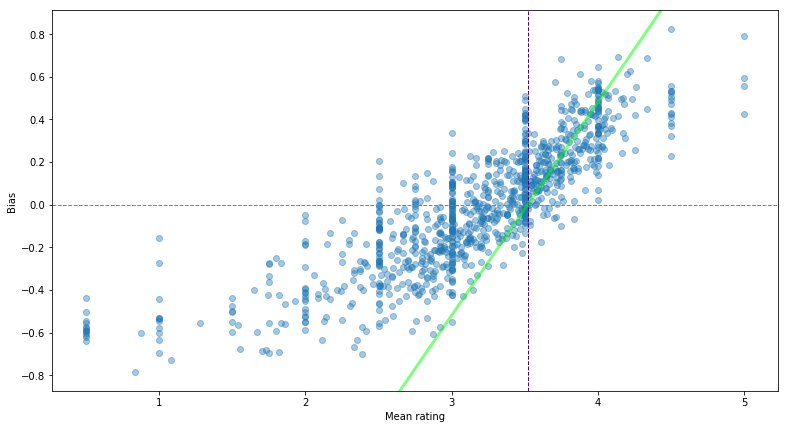

In [ ]:
n = 1000
mini = movies.sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.4)
ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias');

Considering this plot and the list of our highest and lowest bias movies, do you think our learned biases are reasonable? Why or why not?

In [ ]:
#part5.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> Directionally, these biases make sense. Highly rated movies have high biases, and poorly rated movies
have low biases. This agrees with the intuition discussed earlier about biases corresponding to goodness/badness.

But a problem sticks out. We're naively assigning biases which are approximately proportional to movies' 
average ratings - even for movies with few reviews. I'm not convinced that *Gray Lady Down* is the worst
movie ever based on *one* bad review. 

If you're shopping for a can opener, would you rather buy the one with a single 5-star review, or the one
with an average rating of 4.95 over 3,000 reviews? 

This is an especially important problem when dealing with sparse categorical data which can often have long tails
of rare values. We'll talk about an elegant solution to this problem - L2 regularization - in the next lesson.

## Part 6: User biases

It turns out that users have a much less spiky distribution in the dataset (by construction - the MovieLens dataset only included users who gave at least 20 ratings). For this reason, adding per-*user* biases tends to have a more consistently positive effect on accuracy.

Run the cell below to train a model with per-user biases, and compare the results with our earlier models.

Train on 1900000 samples, validate on 100000 samples
Epoch 1/8
 - 4s - loss: 0.8263 - mean_absolute_error: 0.7054 - val_loss: 0.7475 - val_mean_absolute_error: 0.6646
Epoch 2/8
 - 3s - loss: 0.7205 - mean_absolute_error: 0.6521 - val_loss: 0.7256 - val_mean_absolute_error: 0.6531
Epoch 3/8
 - 3s - loss: 0.7000 - mean_absolute_error: 0.6415 - val_loss: 0.7183 - val_mean_absolute_error: 0.6525
Epoch 4/8
 - 3s - loss: 0.6887 - mean_absolute_error: 0.6357 - val_loss: 0.7114 - val_mean_absolute_error: 0.6465
Epoch 5/8
 - 4s - loss: 0.6809 - mean_absolute_error: 0.6319 - val_loss: 0.7079 - val_mean_absolute_error: 0.6432
Epoch 6/8
 - 4s - loss: 0.6732 - mean_absolute_error: 0.6283 - val_loss: 0.7052 - val_mean_absolute_error: 0.6429
Epoch 7/8
 - 3s - loss: 0.6655 - mean_absolute_error: 0.6246 - val_loss: 0.7024 - val_mean_absolute_error: 0.6409
Epoch 8/8
 - 3s - loss: 0.6580 - mean_absolute_error: 0.6209 - val_loss: 0.7013 - val_mean_absolute_error: 0.6418


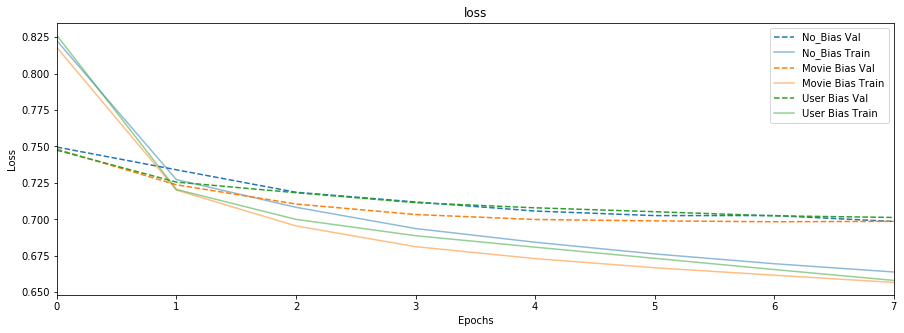

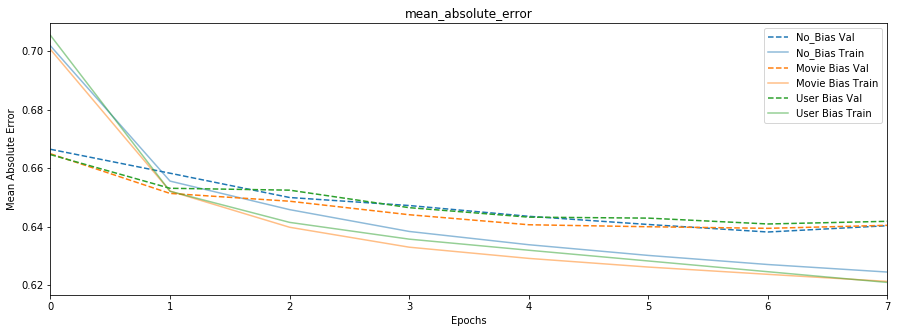

In [ ]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

bias_embedded = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                       # It's typical to initialize embeddings to zero (rather than random noise)
                                       embeddings_initializer='zeros',
                                      )(user_id_input)
user_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, user_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

history_ubias = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);
plot_history([ 
    ('no_bias', history),
    ('movie bias', history_bias),
    ('user bias', history_ubias),
]);

In [ ]:
####################################
########### SCRATCH BELOW ##########
####################################

# Scratch space. Other exercise ideas.

## Experimenting with embedding sizes

In the lesson, we (fairly arbitrarily) chose an embedding size of 8 for both movies and users. The size of embeddings is a hyperparameter we can experiment with to improve our results. Larger embeddings give the model more capacity, meaning they can potentially learn more detailed representations. On the other hand, it increases the model's ability to 'memorize' details of the training data that don't generalize well to unseen data.

Note that the size of our movie embeddings and our user embeddings need not be the same. Do you have a hunch about whether one should have bigger embeddings than the other?

Try experimenting with a few different embedding sizes. Can you improve our loss on the validation data? How do different embedding sizes affect the training loss?

Hint: [this TensorFlow tutorial](https://www.tensorflow.org/guide/feature_columns) gives a general rule of thumb for setting the embedding size of a categorical variable: the 4th root of the number of possible values.

## . adding auxiliary features

#### DB: I really like auxiliary information.  I think it makes the distinction with embeddings more concrete.  I've also seen applications where it's helped a lot, so it'd be good for users to know. I'd try to avoid adding issues of padding here, since we're still just trying to intro the concepts in embeddings.
(Note: question of how to incorporate genre is actually a great prelude to the stuff talked about in the cooking problem. Movies have varying numbers of genre tags, so need some way to deal w/ variable-sized bags of categorical variables. Padding, combining embeddings. Just like cooking problem.)

## . Movie embeddings only (thought experiment)

Mary the movie buff has decided to train a variant of our model. She thinks that movies have a lot of interesting dimensions of variation, and are highly useful for our prediction task, so she allocates a lot more capacity for them - she increases the embedding size from 32 to 128.

On the other hand, she thinks that differences between users are too small to pick out from the noise, so she doesn't train any user embeddings at all.

There's a fundamental issue with her model. Do you see what it is? How would you explain it to her?

*Solution:* Regardless of how big she makes the embeddings, or how many hidden layers she adds, as long as her model only takes movie ids as inputs, it's equivalent to a simple linear model that learns one rating per movie id. Therefore, she might as well just train a simple linear regression model directly - or even calculate the optimal values per movie directly, which is just its mean rating. 

## . clamping output range (spicy)

#### DB: I'd prefer questions that are conceptually about embeddings. This seems like an interesting question, but it's not clear to me that it's topical to this course.
We know that ratings can only ever take on the values `{0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}`.

Can we help our model out by forcing its output into that range? Should we?

### pt. 1

If our model makes a prediction less than 0.5, we're guaranteed to get a better result if we bump it up to 0.5. Similarly if it makes predictions above 5.0. But is it doing this? 

Calculate some predictions on the training data and on the validation data. Do you see any predictions outside the range `[0.5, 5.0]`? 

### pt2. 

Modify the code below to prevent the model from making predictions outside the allowable range of outputs, then try training it. How do results compare to the original model?

Solution: Change the final layer's activation from linear to a function with a fixed range (sigmoid or tanh). From there, you'll need to use a Lambda Layer to scale the output range to `[0.5, 5]` by some addition and multiplication. Alternatively: scale the `y` values ahead of time to the range `[0, 1]` (or `[-1, 1]`, if using tanh). But note: now the reported MSE/MAE is not comparable to our other models.


## other

- r12n. encouraging sparsity
- prediction debugging
- thought experiment: regression v multiclass classification

#### DB Ideas: 
- Compare the errors for users who have made different number of recommendations
- ThoughtQuestion with some example use cases. Ask where embeddings would do well and where one-hot encoding would do well.



In [ ]:
# model introspection sandbox
model = model_bias
final = model.layers[-1]
assert isinstance(final, keras.layers.Add)
cfg = model.get_config()
print(cfg.keys())
print(cfg['name'])
f = cfg['layers'][-1]
print(f)
f['inbound_nodes'][0]
#final.outbound_nodes
#final.inbound_nodes[0]
[layer for layer in cfg['layers'] if layer['name'] == 'flatten_1']
blc = [layer for layer in cfg['layers'] if layer['name'] == 'bias'][0]
print()
print(blc.keys(),
    blc['config'],
      sep='\n'
     )